# This is the python script to Goal C) of the thesis
It reloads the exported csv files with lineaments form Goal B) and performs various ways to analyse and illustrate the data (histograms, Rose diagrams etc.)

In [33]:
#from google.colab import drive
#drive.mount('/content/drive')

# Load libraries

In [34]:
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
import scipy.stats as stats
from scipy.stats import norm
import seaborn as sns
import math

from PIL import Image
import urllib.request

# Load CSV files and plot them

Get files from git hub

In [35]:
# Digital elevation model (dem)
#url    = 'https://raw.githubusercontent.com/stfabbri/CAS_thesis/main/DEMs%20and%20Hillshades/dem.csv' #read dem
#dem    = pd.read_csv(url,header=None)
#df_dem = pd.DataFrame(dem)
#cmap   = 'gist_earth'

In [36]:
# load all csv tables as individual data frames
# coordinates indicate 2m increments (e.g., 2 = 4m) and refer to the Swiss Coordinate system CH1903+ in the range
# --> the CV titles refer to Original dataset, and the numbers refer to 55, 99, 1515 Kernel for Gaussian Blur filter (see also python script Part 1)

df_list=[]
path="https://raw.githubusercontent.com/stfabbri/CAS_ADS_Thesis_final/main/CSV-OUTPUT/"
#path = "/content/drive/MyDrive/CSV_tables/"
name = "_image.csv"
index=['RefGeol1','Matlab_Ortho_slim','61','113']
for df_ in index:
    df_i = pd.read_csv("{}{}{}".format(path,df_,name),delimiter=';')
    df_list.append(df_i)
    
# Digital elevation model (dem)
#url    = '/content/drive/MyDrive/CSV_tables/DEM_10_clip_resampled.csv' #read dem
url_dem    = 'https://github.com/stfabbri/CAS_ADS_Thesis_final/blob/main/INPUT_FIGURES/DEM_10_clip_resampled.zip?raw=true'
dem = pd.read_csv(url_dem,compression='zip',header=None, delimiter=';', dtype= 'float64')
df_dem = pd.DataFrame(dem)
cmap   = 'gist_earth'

# omnidirectional hillshade
# cmap = sns.color_palette("Spectral_r", as_cmap=True)
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')

x, y     =  np.linspace(0,20,2), np.linspace(0,20,2)
xv, yv   =  np.meshgrid(x, y)


#############
# Hillshade MULTI directional
#Hillsh_image = mpimg.imread('/content/drive/MyDrive/Final_project_ADS/Hillsh_Multi_2400px.tif')
url_hillshade_Multi = 'https://github.com/stfabbri/CAS_ADS_Thesis_final/blob/main/INPUT_FIGURES/Hillsh_Multi_2400px.tif?raw=true'
with urllib.request.urlopen(url_hillshade_Multi) as url:
    with open('Hillsh_Multi_2400px.tif', 'wb') as f:
        f.write(url.read())
# Assign Name
Hillsh_Multi = mpimg.imread('Hillsh_Multi_2400px.tif')



<Figure size 1200x900 with 0 Axes>

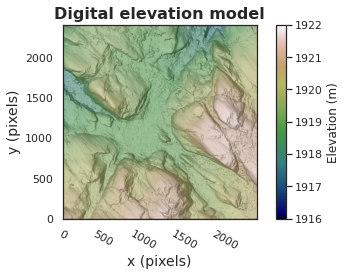

In [37]:
phys_coords = [0,2400,0,2400]

plt.imshow(Hillsh_Multi,extent=phys_coords)
plt.imshow(df_dem,alpha=.5,cmap=cmap,extent=phys_coords)
plt.clim(1916, 1922)

# colorbar
cbar = plt.colorbar(label='Elevation (m)')
cbar.set_alpha(1)
cbar.draw_all()
# labbels
plt.xlabel('x (pixels)',size=14)
plt.ylabel('y (pixels)',size=14)
plt.xticks(np.arange(0, 2400+1, step=500),rotation='-30')
plt.yticks(np.arange(0, 2400+1, step=500),rotation='  0')
plt.title('Digital elevation model',size=16,fontweight="bold")

plt.tight_layout()

#plt.savefig("fig_DEM.png", dpi=300)

In [38]:
# get lengths of individual data frames
length_list=[]
for df in df_list:
    len_i = len(df)
    length_list.append(len_i)

# get positions for splitting 
split_pos   = np.zeros(5)  
split_pos[1::] = np.cumsum(length_list)
split_pos = split_pos.astype(int)

In [39]:
# put all frames together
df_tot = pd.concat(df_list, axis=0)


In [40]:
# Calculate 2D properties (pixel domain)
# 2D mid point coordinates
df_tot['x mid'] = (df_tot['x1'] + df_tot['x2'])/2
df_tot['y mid'] = (df_tot['y1'] + df_tot['y2'])/2

# 2D euclidean distance
df_tot['2D segment length'] = round(np.sqrt((df_tot['x2']-df_tot['x1'])**2 +
                                            (df_tot['y2']-df_tot['y1'])**2),2)

# scale 2D properties to physical dimensions (i.e. in m) for length calculations

# cell size [m] 20 m perimeter divided by 2400 pixels = Cell size
scale_fac = 20/2400

df_tot['x start phys'] = scale_fac*df_tot['x1']
df_tot['y start phys'] = np.absolute(scale_fac*df_tot['y1'])
df_tot['x end phys']   = scale_fac*df_tot['x2']
df_tot['y end phys']   = np.absolute(scale_fac*df_tot['y2'])

# 2D mid point coordinates
df_tot['x mid phys'] = (df_tot['x start phys'] + df_tot['x end phys'])/2
df_tot['y mid phys'] = (df_tot['y start phys'] + df_tot['y end phys'])/2

# 2D euclidean distance
df_tot['2D segment length phys'] = round(np.sqrt((df_tot['x end phys']-df_tot['x start phys'])**2 +
                                            (df_tot['y end phys']-df_tot['y start phys'])**2),2)

# Fault strike orientation
df_tot['fault strike']   = abs(round(np.rad2deg(np.arctan((df_tot['y2']-df_tot['y1'])/
                                                      (df_tot['x2']-df_tot['x1'])))+90,2)-180)

df_tot.head(10)

,x1,y1,x2,y2,x mid,y mid,2D segment length,x start phys,y start phys,x end phys,y end phys,x mid phys,y mid phys,2D segment length phys,fault strike
0,2080.0,2355.0,2076.0,2399.0,2078.0,2377.0,44.18,17.333333,19.625000,17.300000,19.991667,17.316667,19.808333,0.37,174.81
1,719.0,2391.0,741.0,2399.0,730.0,2395.0,23.41,5.991667,19.925000,6.175000,19.991667,6.083333,19.958333,0.20,70.02
2,390.0,2392.0,418.0,2399.0,404.0,2395.5,28.86,3.250000,19.933333,3.483333,19.991667,3.366667,19.962500,0.24,75.96
3,606.0,2371.0,624.0,2397.0,615.0,2384.0,31.62,5.050000,19.758333,5.200000,19.975000,5.125000,19.866667,0.26,34.70
4,432.0,2387.0,435.0,2397.0,433.5,2392.0,10.44,3.600000,19.891667,3.625000,19.975000,3.612500,19.933333,0.09,16.70
5,1382.0,2382.0,1388.0,2393.0,1385.0,2387.5,12.53,11.516667,19.850000,11.566667,19.941667,11.541667,19.895833,0.10,28.61
6,1229.0,2392.0,1242.0,2393.0,1235.5,2392.5,13.04,10.241667,19.933333,10.350000,19.941667,10.295833,19.937500,0.11,85.60
7,1072.0,2381.0,1077.0,2393.0,1074.5,2387.0,13.00,8.933333,19.841667,8.975000,19.941667,8.954167,19.891667,0.11,22.62
8,1242.0,2393.0,1248.0,2392.0,1245.0,2392.5,6.08,10.350000,19.941667,10.400000,19.933333,10.375000,19.937500,0.05,99.46
9,1216.0,2392.0,1229.0,2392.0,1222.5,2392.0,13.00,10.133333,19.933333,10.241667,19.933333,10.187500,19.933333,0.11,90.00


In [41]:
# Calculate 3D properties

# x and y needed switching for the lookup, due to the difference in geograph. and math. coordinates?
df_tot['z start phys'] = df_dem.lookup(df_tot['y1'].astype('int'),df_tot['x1'].astype('int'))
df_tot['z end phys']   = df_dem.lookup(df_tot['y2'].astype('int'),df_tot['x2'].astype('int'))
df_tot['z mid phys']   = df_dem.lookup(round(df_tot['y mid'].astype('int')-.5,0),round(df_tot['x mid'].astype('int')-.5,0))

# 3D euclidean distance
df_tot['3D segment length phys'] = round(np.sqrt((df_tot['x end phys']-df_tot['x start phys'])**2 +
                                            (df_tot['y end phys']-df_tot['y start phys'])**2 +
                                            (df_tot['z end phys']-df_tot['z start phys'])**2),2)

# Get max and min values
column = df_tot["z mid phys"]
max_z  = 100*math.ceil(column.max()/100)
min_z  = 100*math.floor(column.min()/100)

df_tot.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  


,x1,y1,x2,y2,x mid,y mid,2D segment length,x start phys,y start phys,x end phys,y end phys,x mid phys,y mid phys,2D segment length phys,fault strike,z start phys,z end phys,z mid phys,3D segment length phys
0,2080.0,2355.0,2076.0,2399.0,2078.0,2377.0,44.18,17.333333,19.625000,17.300000,19.991667,17.316667,19.808333,0.37,174.81,1920.111,1920.109,1920.116,0.37
1,719.0,2391.0,741.0,2399.0,730.0,2395.0,23.41,5.991667,19.925000,6.175000,19.991667,6.083333,19.958333,0.20,70.02,1920.668,1920.726,1920.698,0.20
2,390.0,2392.0,418.0,2399.0,404.0,2395.5,28.86,3.250000,19.933333,3.483333,19.991667,3.366667,19.962500,0.24,75.96,1920.659,1920.771,1920.722,0.27
3,606.0,2371.0,624.0,2397.0,615.0,2384.0,31.62,5.050000,19.758333,5.200000,19.975000,5.125000,19.866667,0.26,34.70,1920.603,1920.650,1920.628,0.27
4,432.0,2387.0,435.0,2397.0,433.5,2392.0,10.44,3.600000,19.891667,3.625000,19.975000,3.612500,19.933333,0.09,16.70,1920.738,1920.775,1920.756,0.09
5,1382.0,2382.0,1388.0,2393.0,1385.0,2387.5,12.53,11.516667,19.850000,11.566667,19.941667,11.541667,19.895833,0.10,28.61,1920.912,1920.885,1920.900,0.11
6,1229.0,2392.0,1242.0,2393.0,1235.5,2392.5,13.04,10.241667,19.933333,10.350000,19.941667,10.295833,19.937500,0.11,85.60,1921.339,1921.334,1921.337,0.11
7,1072.0,2381.0,1077.0,2393.0,1074.5,2387.0,13.00,8.933333,19.841667,8.975000,19.941667,8.954167,19.891667,0.11,22.62,1921.070,1921.139,1921.087,0.13
8,1242.0,2393.0,1248.0,2392.0,1245.0,2392.5,6.08,10.350000,19.941667,10.400000,19.933333,10.375000,19.937500,0.05,99.46,1921.334,1921.327,1921.331,0.05
9,1216.0,2392.0,1229.0,2392.0,1222.5,2392.0,13.00,10.133333,19.933333,10.241667,19.933333,10.187500,19.933333,0.11,90.00,1921.334,1921.339,1921.340,0.11


In [42]:
#df_tot['y2'].max()
#df_tot['2D segment length'].max()

# Data Cleaning
We remove all lineaments in the matlab dataset and in the python dataset, that full fill not certain conditions

In [43]:
#slice merged df_tot and store in df list 
#saving df to extended DB  

df_index=['RefGeol1','Matlab_Ortho_slim','61','113']
df_list2=[]
len_list=[]
for i in range(0,len(df_index),1):
        df_i= df_tot.iloc[split_pos[i]:split_pos[(i+1)],:]
        df_list2.append(df_i)
        df_i.to_csv(df_index[i],index=False)
              
for i in range(0,len(df_index),1):
        len_i = len(df_list2[i])
        len_list.append(len_i)

Check number of entries (Lineaments) per dataset

In [44]:
# Check amount of lineaments for each dataset, except REF (DO NOT TOUCH!)
for i in range(0,len(df_index),1):
    print(len_list[i],'entries for',df_index[i])

4544 entries for RefGeol1
2457 entries for Matlab_Ortho_slim
1000 entries for 61
1717 entries for 113


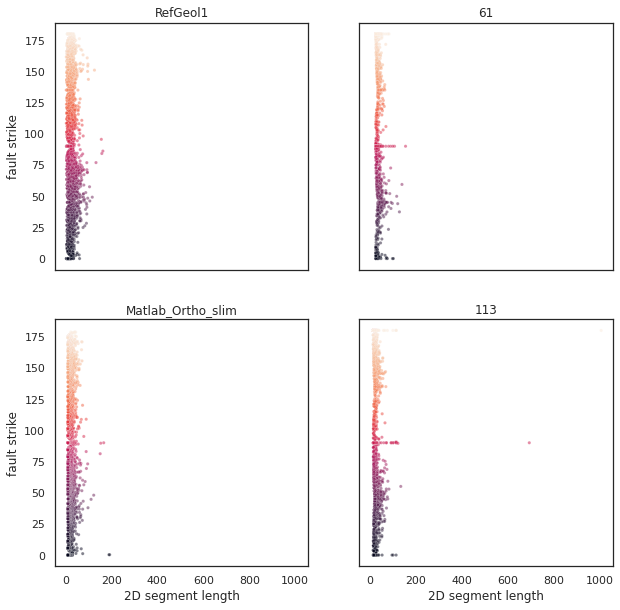

In [45]:
#FIGURES before cleaning
cmap ="rocket"
f_vis1, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')
degree = ''
i=0 # i=0 for GeolRef, 1 for Matlab results, 2 for 61, 3 for 113
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 7:
          g=sns.scatterplot(data=df_list2[i],x = '2D segment length',y = 'fault strike',s=3)
          #g.set(xlim=(0, 100))
          #sns.histplot(data=df_list2[i],x='fault strike',bins=20)
          axes[k,j].set_title("{}{}".format(index[i],degree))
          axes[k,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
          axes[k,j].set_ylim=(1,150)
        else:
            sns.scatterplot(data = df_list2[i], x = '2D segment length', y= 'fault strike', hue = 'fault strike',
                            legend=False, palette=cmap, ax=axes[k,j], size=3,
                            sizes=(10,500), alpha=0.5)
            axes[k,j].set_title("{}{}".format(index[i],degree))
            #axes[k,j].set_ylim=(1,150)
            
            
        i=i+1
#df_tot['2D segment length']

In [46]:
for i in range(1,4):
  df_tot_ind1 = df_list2[i][ (df_list2[i]['2D segment length'] >= 180) ].index # remove lineaments larger 180 pixels
  df_list2[i].drop(df_tot_ind1, inplace=True)
  df_tot_ind2 = df_list2[i][ (df_list2[i]['fault strike'] == 90) & (df_list2[i]['2D segment length'] >= 80) ].index
  df_list2[i].drop(df_tot_ind2, inplace=True)
  df_tot_ind3 = df_list2[i][ (df_list2[i]['fault strike'] == 180) & (df_list2[i]['2D segment length'] >= 80) ].index
  df_list2[i].drop(df_tot_ind3, inplace=True)
  df_tot_ind4 = df_list2[i][ (df_list2[i]['fault strike'] == 0) & (df_list2[i]['2D segment length'] >= 80) ].index
  df_list2[i].drop(df_tot_ind4, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [47]:
# Check if lineaments have been removed from data
print(len(df_list2[1]))
print(len(df_list2[2]))
print(len(df_list2[3]))

2454
992
1702


In [48]:
#df_list2[0]

## Plot fault strike vs segment length AFTER Cleaning

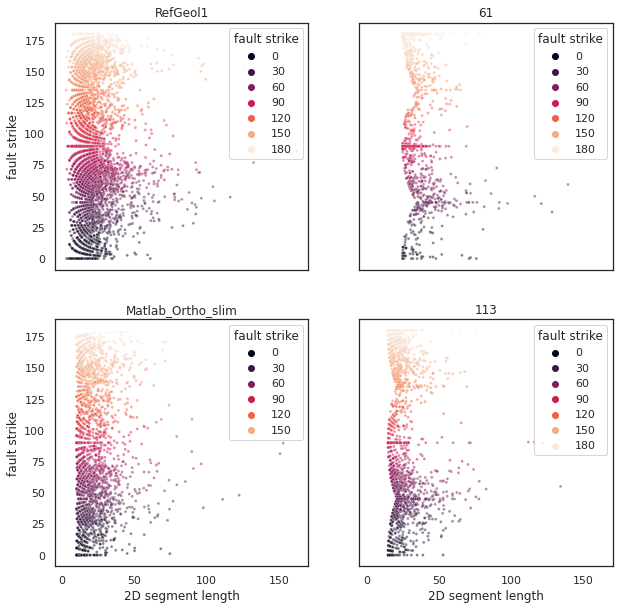

In [49]:
#FIGURES AFTER cleaning
cmap ="rocket"

f_vis1, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')
degree = ''
i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 7:
          g=sns.scatterplot(data=df_list2[i],x = '2D segment length',y = 'fault strike',s=8)
          #g.set(xlim=(0, 100))
          #sns.histplot(data=df_list2[i],x='fault strike',bins=20)
          axes[k,j].set_title("{}{}".format(index[i],degree))
          axes[k,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
          #axes[k,j].set_ylim=(1,150)
        else:
            sns.scatterplot(data = df_list2[i], x = '2D segment length', y= 'fault strike', hue = 'fault strike', s=8,
                            legend=True, palette=cmap, ax=axes[k,j],
                            sizes=(10,500), alpha=0.5)
            axes[k,j].set_title("{}{}".format(index[i],degree))
            #axes[k,j].set_ylim=(1,150)
            
            
        i=i+1
#df_tot['2D segment length']


In [50]:
#degree = '$^{\circ}$'
#print(degree)

In [51]:
# flip physcial y-coordinates upside-down for plotting
for i in range(4):
  df_list2[i]['y start phys'] = 20-df_list2[i]['y start phys']
  df_list2[i]['y end phys'] = 20-df_list2[i]['y end phys']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.05, 0.5, 'Y (m)')

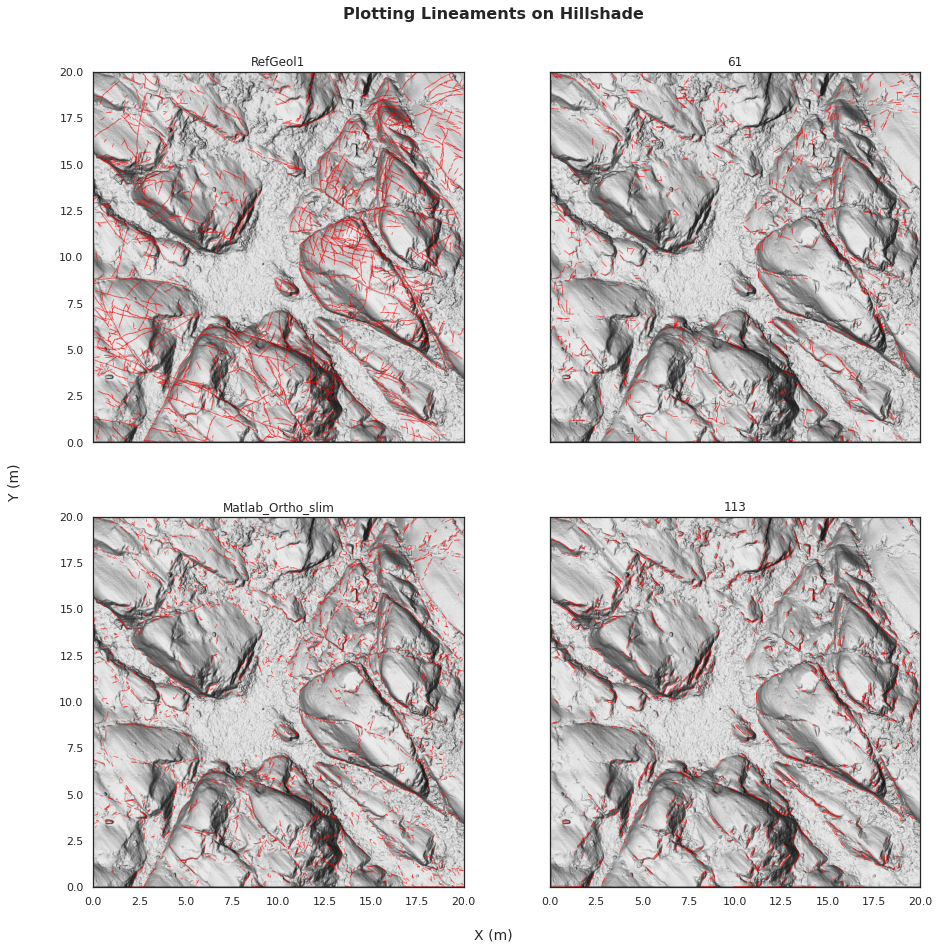

In [52]:
# line check - slow due number of lines
#Hillsh_image = mpimg.imread('/content/drive/MyDrive/Final_project_ADS/Hillsh_Multi_2400px.tif')
Hillsh_Multi = mpimg.imread('Hillsh_Multi_2400px.tif')

phys_coords = [0,20,0,20]

f_lines, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True, facecolor='w', edgecolor='k')
segm_width = 1
alpha_val  = .5
i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        axes[k,j].plot((df_list2[i]['x start phys'],df_list2[i]['x end phys']),
                       (df_list2[i]['y start phys'],df_list2[i]['y end phys']),
                        color='red',alpha=alpha_val,linewidth=segm_width)
        axes[k,j].set_title("{}{}".format(index[i],degree))
        
        axes[k,j].imshow(Hillsh_Multi,extent=phys_coords)
        
        i=i+1
        
# make title and subtitles
f_lines.suptitle('Plotting Lineaments on Hillshade', y=0.94, fontsize=16, fontweight='bold')
plt.setp(axes, xlabel='', ylabel='')
f_lines.text(0.5, 0.08, 'X (m)', ha='center', va='center', fontsize=14)
f_lines.text(0.05, 0.5, 'Y (m)', ha='left'  , va='center', fontsize=14, rotation='vertical')

#plt.savefig("fig_Calculated_line_segments.png", dpi=300)

In [53]:
# flip physcial y-coordinates (IMPORTANT TO execute)
for i in range(4):
  df_list2[i]['y mid phys'] = 20-df_list2[i]['y mid phys']
  #df_list2[i]['y end phys'] = 20-df_list2[i]['y end phys']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
# Orientation & Lengths
# Attribute comparison - as mid points
#Hillsh_image = mpimg.imread('/content/drive/MyDrive/Final_project_ADS/Hillsh_Multi_2400px.tif')
Hillsh_Multi = mpimg.imread('Hillsh_Multi_2400px.tif')

phys_coords = [0,20,0,20]

sns.set(style="white", palette="muted", color_codes=True)
cmap ="rocket"
mkrsize = 5
alpha_val = 0.8
f_vis1, axes = plt.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True, facecolor='w', edgecolor='k')

# plot mid points
i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 5:
            sns.scatterplot(data = df_list2[i], x = 'x mid phys', y= 'y mid phys', hue = 'fault strike', 
                            legend=False, palette=cmap, ax=axes[k,j], size='3D segment length phys',
                            sizes=(8,400), alpha=alpha_val)
            axes[k,j].set_title(index[i])
            axes[k,j].legend(bbox_to_anchor=(0, 0), loc="best", borderaxespad=0.)
            axes[k,j].imshow(Hillsh_Multi,extent=phys_coords) 
        else:
            sns.scatterplot(data = df_list2[i], x = 'x mid phys', y= 'y mid phys', hue = 'fault strike',
                            legend=False, palette=cmap, ax=axes[k,j], size='3D segment length phys',
                            sizes=(8,400), alpha=alpha_val)
            axes[k,j].set_title(index[i])
            axes[k,j].imshow(Hillsh_Multi,extent=phys_coords)
        i=i+1
        
# make title and subtitles
f_vis1.suptitle('Fault strike and Length', y=0.94, fontsize=18, fontweight='bold')  
plt.setp(axes, xlabel='', ylabel='')
f_vis1.text(0.45, 0.08, 'X (m)', ha='center', va='center', fontsize=18)
f_vis1.text(0.05, 0.5 , 'Y (m)', ha='left'  , va='center', fontsize=18, rotation='vertical')
#plt.savefig("fig_fault_strike_and_length.png", dpi=300)

Output hidden; open in https://colab.research.google.com to view.

In [55]:
# Attribute comparision - in data dimensions
# absolute key values for orientation
r_index=['mean_or','med_or','std_or','mean_2D_length','med_2D_length','std_2D_length','mean_3D_length','med_3D_length','std_3D_length']
Res_stat=np.zeros((len(r_index),len(index)))
k=0                                                            
for df in df_list2:                                                 
    Res_stat[0,k]=round(df['fault strike'].mean(),1)
    Res_stat[1,k]=round(df['fault strike'].median(),1)
    Res_stat[2,k]=round(df['fault strike'].std(),1)
    Res_stat[3,k]=round(df['2D segment length phys'].mean(),1)
    Res_stat[4,k]=round(df['2D segment length phys'].median(),1)
    Res_stat[5,k]=round(df['2D segment length phys'].std(),1)
    Res_stat[6,k]=round(df['3D segment length phys'].mean(),1)
    Res_stat[7,k]=round(df['3D segment length phys'].median(),1)
    Res_stat[8,k]=round(df['3D segment length phys'].std(),1)
    k=k+1
#print(Res_stat)
df_stats = pd.DataFrame(Res_stat, columns=index, index=r_index)
df_stats

,RefGeol1,Matlab_Ortho_slim,61,113
mean_or,91.3,83.1,99.3,92.0
med_or,82.9,73.0,90.0,76.9
std_or,50.0,50.5,54.0,56.3
mean_2D_length,0.2,0.2,0.3,0.2
med_2D_length,0.2,0.2,0.3,0.2
std_2D_length,0.1,0.1,0.1,0.1
mean_3D_length,0.2,0.2,0.3,0.2
med_3D_length,0.2,0.2,0.3,0.2
std_3D_length,0.1,0.1,0.1,0.1


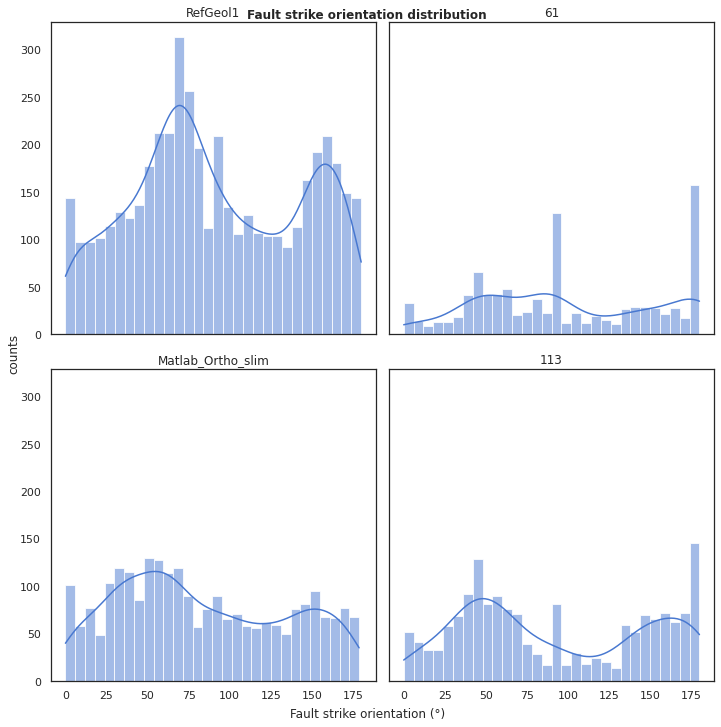

In [56]:
#orientation histograms

x = np.linspace(0,180,180)
f_his1, axes = plt.subplots(2, 2, figsize=(10, 10),sharex=True, sharey=True)
i=0
for j in range(0,2,1):
    for k in range(0,2,1):
    #axes[k,j].plot(x, norm.pdf(x,df_stats.iloc[0,l],df_stats.iloc[2,l]),'b-', lw=2,)   #simple unimodal norm. pdf fit
        sns.histplot(df_list2[i]['fault strike'], kde=True,ax=axes[k,j],bins=30)
        axes[k,j].set_title("{}{}".format(index[i],degree))
        i=i+1
    
# make title and subtitles
f_his1.suptitle('Fault strike orientation distribution',fontsize='12',ha='center',va='top' ,fontweight='bold')
plt.setp(axes, xlabel='', ylabel='')
f_his1.text(0.5, 0.0, 'Fault strike orientation (°)', ha='center', va='center', fontsize=12)
f_his1.text(0.0, 0.5, 'counts', ha='left', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
#plt.savefig("fig_fault_strike_histograms.png", dpi=300)

Some statistics on Circular Data

In [57]:
import cmath
import numpy as np
import scipy.stats as stats

# Circular mean of angle data(default to degree)
for i in range(4):
  a = np.deg2rad(df_list2[i]['fault strike'])
  angles_complex = np.frompyfunc(cmath.exp, 1, 1)(a * 1j)
  mean = cmath.phase(angles_complex.sum()) % (2 * np.pi)
  r_mean = round(mean,2)
  #print("{}{}".format(index[i])
  print("Circular mean of",format(index[i]) )
  print("Mean=", np.rad2deg(r_mean))

Circular mean of RefGeol1
Mean= 90.52733163067008
Circular mean of Matlab_Ortho_slim
Mean= 80.78704911344607
Circular mean of 61
Mean= 97.97578296737078
Circular mean of 113
Mean= 89.38141604040842


In [58]:
# Circular variance of angle data(default to degree)
for i in range(4):
  r =abs(angles_complex.sum()) / len(df_list2[i]['fault strike'])
  print("Circular Variance:", format(index[i]))
  print("1 - R=",round(1-r,2))
  print("R=",round(r,2))

Circular Variance: RefGeol1
1 - R= 0.78
R= 0.22
Circular Variance: Matlab_Ortho_slim
1 - R= 0.6
R= 0.4
Circular Variance: 61
1 - R= 0.01
R= 0.99
Circular Variance: 113
1 - R= 0.42
R= 0.58


In [59]:
# MAKE A COPY
df_tot

,x1,y1,x2,y2,x mid,y mid,2D segment length,x start phys,y start phys,x end phys,y end phys,x mid phys,y mid phys,2D segment length phys,fault strike,z start phys,z end phys,z mid phys,3D segment length phys
0,2080.0,2355.0,2076.0,2399.0,2078.0,2377.0,44.18,17.333333,0.375000,17.300000,0.008333,17.316667,0.191667,0.37,174.81,1920.111,1920.109,1920.116,0.37
1,719.0,2391.0,741.0,2399.0,730.0,2395.0,23.41,5.991667,0.075000,6.175000,0.008333,6.083333,0.041667,0.20,70.02,1920.668,1920.726,1920.698,0.20
2,390.0,2392.0,418.0,2399.0,404.0,2395.5,28.86,3.250000,0.066667,3.483333,0.008333,3.366667,0.037500,0.24,75.96,1920.659,1920.771,1920.722,0.27
3,606.0,2371.0,624.0,2397.0,615.0,2384.0,31.62,5.050000,0.241667,5.200000,0.025000,5.125000,0.133333,0.26,34.70,1920.603,1920.650,1920.628,0.27
4,432.0,2387.0,435.0,2397.0,433.5,2392.0,10.44,3.600000,0.108333,3.625000,0.025000,3.612500,0.066667,0.09,16.70,1920.738,1920.775,1920.756,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,120.0,943.0,139.0,958.0,129.5,950.5,24.21,1.000000,7.858333,1.158333,7.983333,1.079167,7.920833,0.20,51.71,1918.540,1918.549,1918.548,0.20
1713,79.0,891.0,88.0,919.0,83.5,905.0,29.41,0.658333,7.425000,0.733333,7.658333,0.695833,7.541667,0.25,17.82,1918.451,1918.497,1918.472,0.25
1714,921.0,331.0,928.0,346.0,924.5,338.5,16.55,7.675000,2.758333,7.733333,2.883333,7.704167,2.820833,0.14,25.02,1919.011,1919.024,1919.014,0.14
1715,1357.0,1826.0,1373.0,1833.0,1365.0,1829.5,17.46,11.308333,15.216667,11.441667,15.275000,11.375000,15.245833,0.15,66.37,1919.942,1919.954,1919.942,0.15


In [60]:
# Alternative to Histogram
strikes = df_list2[3]['fault strike']

bin_edges = np.arange(-5, 366, 10)
number_of_strikes, bin_edges = np.histogram(strikes, bin_edges)
number_of_strikes[0] += number_of_strikes[-1]
half = np.sum(np.split(number_of_strikes[:-1], 2), 0)
two_halves = np.concatenate([half, half])

Text(0.5, 1.1, 'Rose Diagram of 113')

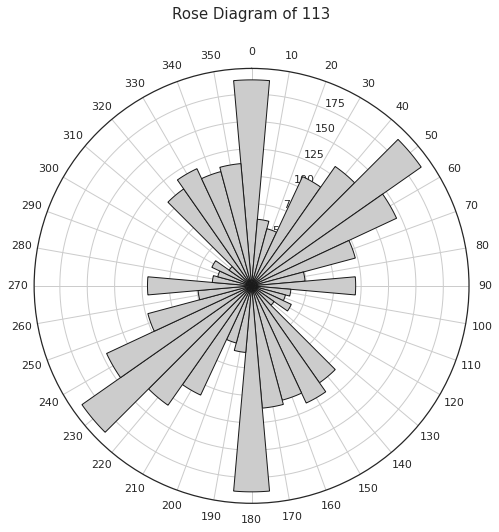

In [61]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='polar')

ax.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves, 
       width=np.deg2rad(10), bottom=0.0, color='.8', edgecolor='k')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 10), labels=np.arange(0, 360, 10))
#ax.set_rgrids(np.arange(1, two_halves.max() + 1, 2), angle=0, weight= 'black')
ax.set_title('Rose Diagram of 113', y=1.10, fontsize=15)